In [104]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import numpy as np

Récupération des données sur Alpha Vantage grâce à une API

In [105]:
# Définis tes paramètres
api_key = 'DMKEDBILO6JEHI37' #clé de Lucien Bedel, 25 requests/j
from_symbol = 'EUR'
to_symbol = 'USD'
output_size = 'compact'  # 'compact' pour les 100 derniers points, 'full' pour tout l'historique

# Construis l'URL de l'API
url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_symbol}&to_symbol={to_symbol}&outputsize={output_size}&datatype=csv&apikey={api_key}'

# Fais la requête et sauvegarde le contenu dans un DataFrame
response = requests.get(url)
csv_data = response.content.decode('utf-8')

In [106]:
df = pd.read_csv(io.StringIO(csv_data))

In [107]:
# Affiche les premières lignes pour vérifier
print(df)

# Sauvegarde le DataFrame dans un fichier CSV si nécessaire
df.to_csv('fx_data_usd_eur.csv', index=False)

      timestamp     open     high      low    close
0    2024-10-30  1.08185  1.08593  1.08128  1.08353
1    2024-10-29  1.08167  1.08284  1.08167  1.08284
2    2024-10-28  1.08168  1.08263  1.07704  1.08168
3    2024-10-27  1.07966  1.08272  1.07827  1.07966
4    2024-10-24  1.08241  1.08425  1.08119  1.08241
..          ...      ...      ...      ...      ...
96   2024-06-17  1.07407  1.07612  1.07111  1.07407
97   2024-06-16  1.07022  1.07262  1.06876  1.07022
98   2024-06-13  1.07388  1.07458  1.06682  1.07388
99   2024-06-12  1.08132  1.08178  1.07538  1.08132
100  2024-06-11  1.07403  1.08518  1.07350  1.07403

[101 rows x 5 columns]


In [108]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
# Tri des données par date (si nécessaire)
df = df.sort_values(by='timestamp')

# Différents algo de lissage

1) Moyenne mobile

In [109]:
#Réduit le bruit quotidien en conservant les tendances majeures
df['smoothedMM'] = df['close'].rolling(window=30).mean()  # Lissage avec une fenêtre de 30 jours

2) Moyenne mobile exponentielle

In [110]:
#Cette méthode est une MM qui donne plus de poids aux valeurs récentes, aide à capter les changements de tendance
df['smoothedMME'] = df['close'].ewm(span=30, adjust=False).mean()  # EMA avec une fenêtre de 30 jours


3) Filtre de Savitzky-Golay

In [111]:
#Le filtre de Savitzky-Golay peut aussi être utile pour lisser sans trop de retard, en particulier s’il est appliqué pour détecter des tendances courbes ou non linéaires.
'''
1. window_length
Description : Il s'agit de la taille de la fenêtre glissante, c’est-à-dire le nombre de points de données utilisés pour ajuster chaque polynôme local.
Rôle : Plus la fenêtre est grande, plus le lissage sera important (et plus les variations rapides seront atténuées). En revanche, une petite fenêtre rend le lissage moins prononcé et permet de capturer davantage les fluctuations locales.
Valeur : window_length doit être un entier impair (par exemple, 5, 7, 11, etc.), et au moins égal à polyorder + 1. Un choix courant est entre 5 et 15 points, en fonction de la fréquence des données et du niveau de bruit.
2. polyorder
Description : C’est l’ordre du polynôme utilisé pour ajuster les points dans chaque fenêtre.
Rôle : Un ordre de polynôme plus élevé permet de capturer des variations plus complexes dans les données. Par exemple :
polyorder=1 : le filtre lisse chaque sous-ensemble avec une droite (équivalent à un lissage linéaire).
polyorder=2 : utilise un polynôme du second degré (capture des courbes simples).
polyorder=3 ou plus : permet de capturer des courbes plus complexes, mais peut aussi risquer de surajuster les données si le bruit est élevé.
'''

from scipy.signal import savgol_filter

df['smoothedSG'] = savgol_filter(df['close'], window_length=11, polyorder=2)  # Exemple de filtre Savitzky-Golay


4) Filtre de Kalman

In [112]:
%pip install filterpy
import sys
print(sys.executable)

Note: you may need to restart the kernel to use updated packages.
C:\Users\eloim\anaconda3\python.exe


In [113]:
#pip install filterpy
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# Création d'un filtre de Kalman
def apply_kalman_filter(data):
    # Initialisation du filtre de Kalman
    kf = KalmanFilter(dim_x=2, dim_z=1)  # dim_x est le nombre d'états, dim_z est le nombre de mesures

    # Définition des matrices d'état
    dt = 1  # Intervalle de temps entre chaque mesure
    kf.F = np.array([[1, dt], [0, 1]])  # Modèle de transition
    kf.H = np.array([[1, 0]])           # Modèle d'observation

    kf.P *= 1000.0      # Incertitude initiale
    kf.R = 0.1          # Bruit de mesure
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)  # Bruit de processus

    # Liste pour stocker les valeurs filtrées
    smoothed_data = []

    # Position initiale
    kf.x = np.array([[data[0]], [0]])  # Valeur initiale et vitesse

    # Appliquer le filtre de Kalman sur chaque point de données
    for value in data:
        kf.predict()
        kf.update([value])
        smoothed_data.append(kf.x[0][0])  # Ajoute la position estimée

    return smoothed_data

In [114]:
df['smoothedK'] = apply_kalman_filter(df['close'].values)

4) Filtre de Butterworth

In [115]:
from scipy.signal import butter, filtfilt

# Define a low-pass Butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply Butterworth filter to the FX rate
fs = 1  # Sampling frequency (1 per day if daily data)
cutoff = 0.1  # Adjust cutoff frequency to experiment with trend capturing
df['smoothedButterworth'] = butter_lowpass_filter(df['close'], cutoff, fs)

5) Filtre Mediane Mobile

In [116]:
df['smoothedMedian'] = df['close'].rolling(window=15).median()  # Adjust window size as needed

# Cours VS Lissages

In [117]:
df.dropna(inplace=True)

On met tous les lissages et la courbe initiale pour pouvoir comparer

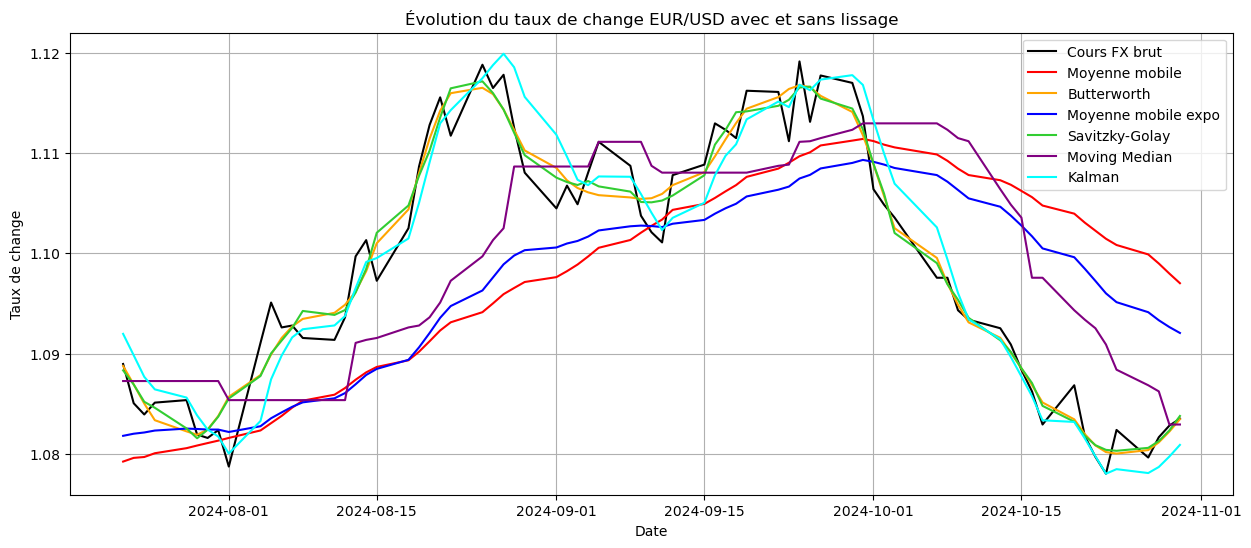

In [118]:
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['close'], label='Cours FX brut', color='black')
plt.plot(df['timestamp'], df['smoothedMM'], label='Moyenne mobile', color='red')
plt.plot(df['timestamp'], df['smoothedButterworth'], label='Butterworth', color='orange')
plt.plot(df['timestamp'], df['smoothedMME'], label='Moyenne mobile expo', color='blue')
plt.plot(df['timestamp'], df['smoothedSG'], label='Savitzky-Golay', color='limegreen')
plt.plot(df['timestamp'], df['smoothedMedian'], label='Moving Median', color='purple')
plt.plot(df['timestamp'], df['smoothedK'], label='Kalman', color='cyan')
plt.xlabel('Date')
plt.ylabel('Taux de change')
plt.title(f'Évolution du taux de change {from_symbol}/{to_symbol} avec et sans lissage')
plt.legend()
plt.grid(True)

#plt.gcf().autofmt_xdate(rotation=45)
plt.show()


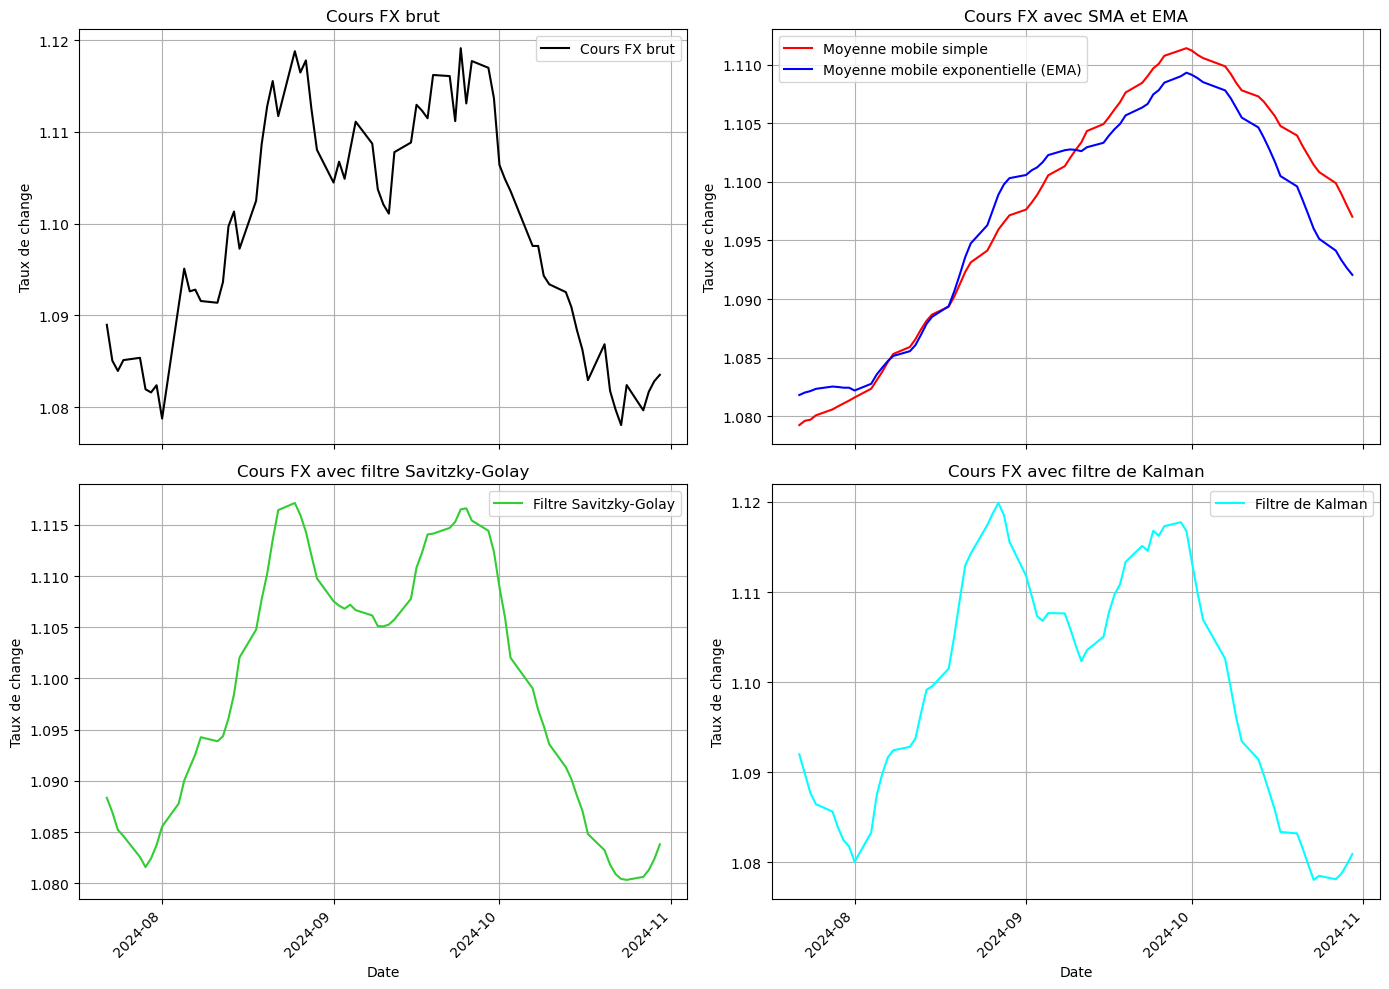

In [119]:
import matplotlib.dates as mdates
# Affichage des graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cours FX brut
axes[0, 0].plot(df['timestamp'], df['close'], color='black', label='Cours FX brut')
axes[0, 0].set_title("Cours FX brut")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Taux de change")
axes[0, 0].grid(True)
axes[0, 0].legend()

# Cours FX lissé - moyenne mobile simple
axes[0, 1].plot(df['timestamp'], df['smoothedMM'], color='red', label='Moyenne mobile simple')
axes[0, 1].plot(df['timestamp'], df['smoothedMME'], color='blue', label='Moyenne mobile exponentielle (EMA)')
axes[0, 1].set_title("Cours FX avec SMA et EMA")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Taux de change")
axes[0, 1].grid(True)
axes[0, 1].legend()



# Cours FX lissé - Savitzky-Golay
axes[1, 0].plot(df['timestamp'], df['smoothedSG'], color='limegreen', label='Filtre Savitzky-Golay')
axes[1, 0].set_title("Cours FX avec filtre Savitzky-Golay")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Taux de change")
axes[1, 0].grid(True)
axes[1, 0].legend()

# Cours FX lissé - filtre de Kalman
axes[1, 1].plot(df['timestamp'], df['smoothedK'], color='cyan', label='Filtre de Kalman')
axes[1, 1].set_title("Cours FX avec filtre de Kalman")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Taux de change")
axes[1, 1].grid(True)
axes[1, 1].legend()


# Configuration des dates sur l'axe des abscisses
for ax in axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Fixe l'intervalle à un mois
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formate la date
# Ajuste les étiquettes de date
fig.autofmt_xdate(rotation=45)

plt.tight_layout()  # Ajuste l'espacement pour éviter les chevauchements
plt.show()

# Sélection du meilleur lissage

In [120]:
# Example of normalizing the data
df['close_normalized'] = (df['close'] - df['close'].mean()) / df['close'].std()
trend, cycle = hpfilter(df['close_normalized'], lamb=100)
df['smoothedHP_normalized'] = trend * df['close'].std() + df['close'].mean()  # rescale back to original
from statsmodels.tsa.filters.hp_filter import hpfilter


In [121]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_smoothing(original, kalman, savgol, butterworth):
    # Mean Squared Error (MSE) between original and each smoothed version
    mse_kalman = mean_squared_error(original, kalman)
    mse_savgol = mean_squared_error(original, savgol)
    mse_butterworth = mean_squared_error(original, butterworth)
    
    # Signal-to-Noise Ratio (SNR)
    snr_kalman = np.mean(kalman) / np.std(kalman - original)
    snr_savgol = np.mean(savgol) / np.std(savgol - original)
    snr_butterworth = np.mean(butterworth) / np.std(butterworth - original)
    
    # Autocorrelation of Residuals
    residuals_kalman = kalman - original
    residuals_savgol = savgol - original
    residuals_butterworth = butterworth - original
    autocorr_kalman = np.corrcoef(residuals_kalman[:-1], residuals_kalman[1:])[0, 1]
    autocorr_savgol = np.corrcoef(residuals_savgol[:-1], residuals_savgol[1:])[0, 1]
    autocorr_butterworth = np.corrcoef(residuals_butterworth[:-1], residuals_butterworth[1:])[0, 1]
    
    # Display results in a clear format
    print("\n--- Filter Performance Metrics ---")
    print(f"Kalman Filter:\n  MSE: {mse_kalman:.8f}\n  SNR: {snr_kalman:.2f}\n  Autocorrelation: {autocorr_kalman:.4f}\n")
    print(f"Savitzky-Golay Filter:\n  MSE: {mse_savgol:.8f}\n  SNR: {snr_savgol:.2f}\n  Autocorrelation: {autocorr_savgol:.4f}\n")
    print(f"Butterworth Filter:\n  MSE: {mse_butterworth:.8f}\n  SNR: {snr_butterworth:.2f}\n  Autocorrelation: {autocorr_butterworth:.4f}\n")
    
    # Select the filter based on metrics
    if (mse_kalman < mse_savgol and mse_kalman < mse_butterworth and
        snr_kalman > snr_savgol and snr_kalman > snr_butterworth and
        autocorr_kalman < autocorr_savgol and autocorr_kalman < autocorr_butterworth):
        result = "Kalman Filter seems best based on these metrics."
    
    elif (mse_savgol < mse_kalman and mse_savgol < mse_butterworth and
          snr_savgol > snr_kalman and snr_savgol > snr_butterworth and
          autocorr_savgol < autocorr_kalman and autocorr_savgol < autocorr_butterworth):
        result = "Savitzky-Golay Filter seems best based on these metrics."
    
    elif (mse_butterworth < mse_kalman and mse_butterworth < mse_savgol and
          snr_butterworth > snr_kalman and snr_butterworth > snr_savgol and
          autocorr_butterworth < autocorr_kalman and autocorr_butterworth < autocorr_savgol):
        result = "Butterworth Filter seems best based on these metrics."
    
    else:
        result = "The results are mixed; further analysis might be needed."
    
    # Display final decision
    print("\n--- Decision ---")
    print(result)
    return result

# Example usage (replace `original_fx`, `kalman_smoothed`, `savgol_smoothed`, `butterworth_smoothed` with actual data)
result = evaluate_smoothing(df['close'], df['smoothedK'], df['smoothedSG'], df['smoothedButterworth'])


--- Filter Performance Metrics ---
Kalman Filter:
  MSE: 0.00001018
  SNR: 344.70
  Autocorrelation: 0.6160

Savitzky-Golay Filter:
  MSE: 0.00000558
  SNR: 465.13
  Autocorrelation: 0.0152

Butterworth Filter:
  MSE: 0.00000591
  SNR: 452.14
  Autocorrelation: 0.0732


--- Decision ---
Savitzky-Golay Filter seems best based on these metrics.
